In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import sleep
from sklearn import tree, svm

from pandas_datareader import data as pdr
import pandas_ta as ta #commented out for me for now, I (Ben) had some dependency issues

import yfinance as yf
# import quandl as qd # not used, ignor ples
from backtesting import Backtest, Strategy

C:\Users\Staro\.virtualenvs\dsc190-FVH1D0fH\lib\site-packages\backtesting\_plotting.py:45: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
df = pd.read_csv('sp500_daily.csv')
df.Date.max()

'2021-03-10'

In [3]:
df.Date.min()

'2010-01-04'

In [4]:
df.groupby('Date').Date

In [5]:
def generate_daily_timetable(j, k):
    '''aims to generate the MONTHLY table of times for each observe/hold period. The midpoint in this context is where we switch from the observation period len=j to the holding period len=k'''
    j_end = pd.date_range(pd.to_datetime(df.Date.min())+pd.DateOffset(days=j), pd.to_datetime(df.Date.max()), freq=str(k)+"D") # the 'midpoints' for each observe and hold period. 
    j_start = j_end + pd.DateOffset(days=-j) # based on the midpoint, get the start point for each observe and hold period
    k_end = j_end + pd.DateOffset(days=k-1) # based on the midpoint, get the end point for each observe and hold period
    timetable = pd.DataFrame({'j_start': j_start, 'midpoint': j_end, 'k_end': k_end}).infer_objects()
    return timetable, j, k

In [48]:
# get features
data = pd.read_csv('daily_j30_k60_features.csv')
data

,index,adj_close_mean,adj_close_min,adj_close_max,adj_close_std,adj_close_diff_mean,adj_close_diff_min,adj_close_diff_max,adj_close_diff_std,pct_chng_mean,...,SMA_5_std,log_ret_mean,log_ret_min,log_ret_max,log_ret_std,cumprod_last,mom_cumprod_last,rev_cumprod_last,log_ret_last,label
0,0,1138.982852,1073.869995,1178.099976,28.528165,1.100244,-24.719971,41.419922,10.992904,0.000976,...,25.561043,0.000930,-0.022390,0.037053,0.009699,0.039815,0.358708,-0.094005,0.007386,1.0
1,1,1117.527146,1067.949951,1173.599976,36.718511,-3.760999,-43.460083,48.849976,22.986997,-0.002956,...,30.654898,-0.003154,-0.039756,0.043035,0.020127,-0.064093,-0.084155,-0.070879,0.025514,0.0
2,2,1086.437500,1028.060059,1115.010010,21.431599,-0.064736,-74.769897,32.209961,22.780826,0.000146,...,14.183257,-0.000056,-0.070206,0.030850,0.020767,-0.001115,0.116015,0.095036,0.000063,1.0
3,3,1122.253634,1080.290039,1148.670044,20.226617,0.730475,-45.569946,23.840088,13.946638,0.000687,...,17.905030,0.000615,-0.041318,0.020973,0.012248,0.013625,0.162345,0.123332,-0.003088,1.0
4,4,1197.254749,1146.239990,1225.849976,18.670556,2.076001,-19.410034,38.140015,14.138749,0.001761,...,11.539320,0.001694,-0.016338,0.032732,0.011633,0.036223,0.064115,0.030093,-0.001380,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,62,3009.339995,2820.000000,3232.389893,118.798944,13.849500,-60.069824,90.209961,40.041249,0.004393,...,100.714104,0.004301,-0.020713,0.031015,0.013140,0.094530,0.208640,0.382049,-0.007830,0.0
63,63,3249.735906,3155.219971,3351.280029,52.096386,7.673340,-40.360107,42.300049,23.068791,0.002266,...,38.987080,0.002240,-0.012396,0.013317,0.006989,0.050512,0.022253,0.032776,0.000633,0.0
64,64,3345.662276,3236.919922,3419.439941,48.933242,4.171422,-78.650146,67.119873,43.851414,0.001259,...,33.779225,0.001180,-0.024007,0.019945,0.012817,0.026292,0.074093,-0.002936,0.017247,1.0
65,65,3599.062500,3446.830078,3699.120117,58.621400,13.278423,-41.739990,103.669922,35.918752,0.003585,...,42.693185,0.003532,-0.011631,0.029633,0.009871,0.073195,0.138465,0.529320,0.008797,0.0


In [49]:
timedf, j, k = generate_daily_timetable(10,10) # change your values as needed
print(timedf.shape[0])
timedf

408


,j_start,midpoint,k_end
0,2010-01-04,2010-01-14,2010-01-23
1,2010-01-14,2010-01-24,2010-02-02
2,2010-01-24,2010-02-03,2010-02-12
3,2010-02-03,2010-02-13,2010-02-22
4,2010-02-13,2010-02-23,2010-03-04
...,...,...,...
403,2021-01-16,2021-01-26,2021-02-04
404,2021-01-26,2021-02-05,2021-02-14
405,2021-02-05,2021-02-15,2021-02-24
406,2021-02-15,2021-02-25,2021-03-06


# model training

In [50]:
data.iloc[:,-1]

0     1.0
1     0.0
2     1.0
3     1.0
4     1.0
     ... 
62    0.0
63    0.0
64    1.0
65    0.0
66    1.0
Name: label, Length: 67, dtype: float64

# model evaluation

In [51]:
date = pd.read_csv('date.csv').rename(columns={'Date':'date'})
date

,Unnamed: 0,date
0,0.0,2010-01-04
1,1.0,2010-01-05
2,2.0,2010-01-06
3,3.0,2010-01-07
4,4.0,2010-01-08
...,...,...
2810,4077.0,2021-03-04
2811,4078.0,2021-03-05
2812,4081.0,2021-03-08
2813,4082.0,2021-03-09


In [52]:
# pd.merge(timedf[['midpoint']], data[['label']], left_index=True, right_index=True)
data['label']

0     1.0
1     0.0
2     1.0
3     1.0
4     1.0
     ... 
62    0.0
63    0.0
64    1.0
65    0.0
66    1.0
Name: label, Length: 67, dtype: float64

In [61]:
csv_ = 'daily_j30_k60_pct.csv'
performance = pd.read_csv(csv_)[['date','index', 'mom_pct_change','rev_pct_change','SP500_pct_change']].infer_objects()
performance['date'] = pd.to_datetime(performance['date'])
# output = date.merge(performance, how='right',left_index=True, right_index=True)[['date','index', 'mom_pct_change','rev_pct_change','SP500_pct_change']]
# output
# output.to_csv(csv_)
performance = performance.set_index('date')

performance = performance.merge(data[['label']], left_on='index', right_index=True) #example
performance['best_pct_change'] = performance.apply(lambda x: x['mom_pct_change'] if x['label']==1 else x['rev_pct_change'] if x['label']==-1 else 0,axis=1) # todo build more models and get their outputs. output results here

performance[['mom_return','rev_return', 'best_return']] = performance[['mom_pct_change','rev_pct_change', 'best_pct_change',]].apply(lambda x: (x+1).cumprod()-1)
performance

,index,mom_pct_change,rev_pct_change,SP500_pct_change,label,best_pct_change,mom_return,rev_return,best_return
date,,,,,,,,,
2010-01-04,0.0,0.000000,0.000000,0.016043,1.0,0.000000,0.000000,0.000000,0.000000
2010-01-05,0.0,0.034084,-0.001461,0.003116,1.0,0.034084,0.034084,-0.001461,0.034084
2010-01-06,0.0,0.024546,-0.008515,0.000546,1.0,0.024546,0.059467,-0.009964,0.059467
2010-01-07,0.0,0.056825,-0.013797,0.004001,1.0,0.056825,0.119671,-0.023624,0.119671
2010-01-08,0.0,-0.000452,0.005071,0.002882,1.0,-0.000452,0.119166,-0.018672,0.119166
...,...,...,...,...,...,...,...,...,...
2021-03-04,66.0,0.016275,-0.010360,-0.013417,1.0,0.016275,16.456370,4.666414,14.987812
2021-03-05,66.0,0.043806,0.033756,0.019496,1.0,0.043806,17.221071,4.857688,15.688180
2021-03-08,66.0,-0.010056,0.010515,-0.005359,1.0,-0.010056,17.037843,4.919283,15.520367


<AxesSubplot:title={'center':'Comparison of Models against Baseline (J=10, k=10)'}, xlabel='date'>

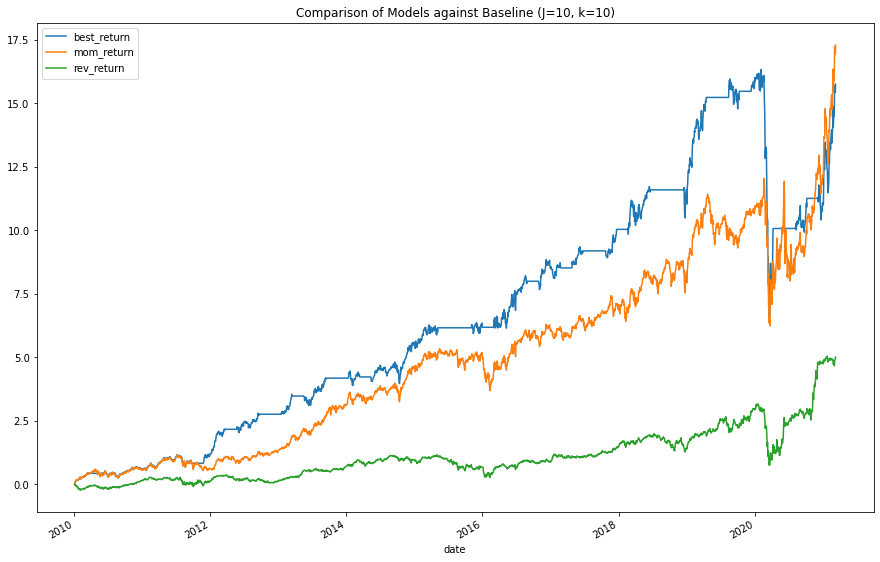

In [65]:
performance[['best_return','mom_return','rev_return']].plot(figsize=(15,10), title='Comparison of Strategies against Baseline (J='+str(j)+', k='+str(k)+')')

<AxesSubplot:xlabel='date'>

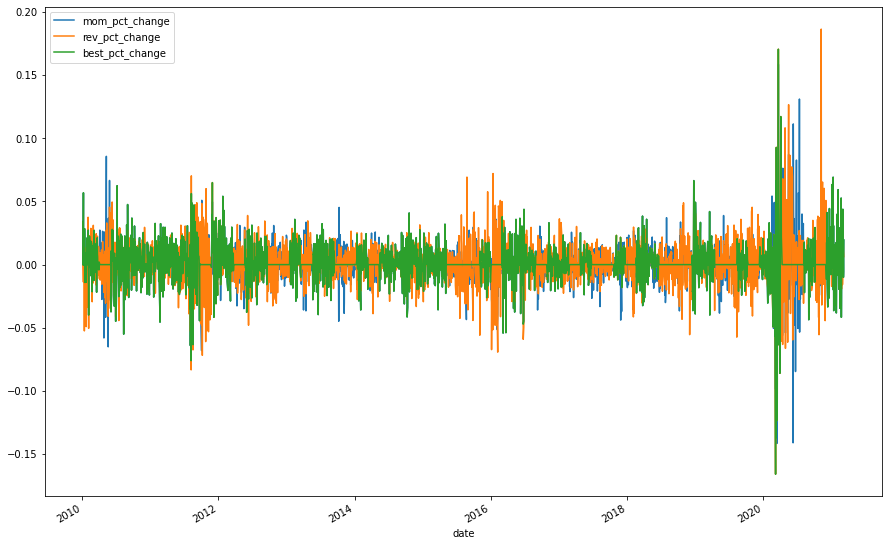

In [63]:
performance[['mom_pct_change','rev_pct_change', 'best_pct_change']].plot(figsize=(15,10), title='Comparison of Model percent ratios against Baseline (J='+str(j)+', k='+str(k)+')')

<AxesSubplot:title={'center':'Comparison of Model period means against Baseline (J=10, k=10)'}, xlabel='date'>

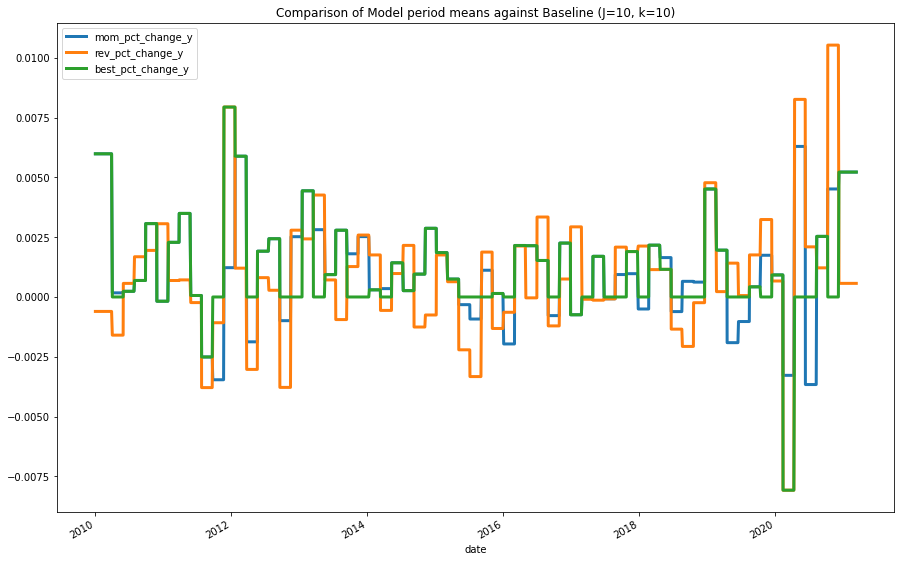

In [75]:
performance.merge(performance.groupby('index')[['mom_pct_change','rev_pct_change', 'best_pct_change']].mean(), left_on='index', right_index=True)[['mom_pct_change_y','rev_pct_change_y','best_pct_change_y']].plot(figsize=(15,10), title='Comparison of Model period means against Baseline (J='+str(j)+', k='+str(k)+')', linewidth=3)
# haha what is this even. its the above plot but 'averaged' out per period